In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 11.0,
    'theta': 0.04,
    'xi': 0.9
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

1.09


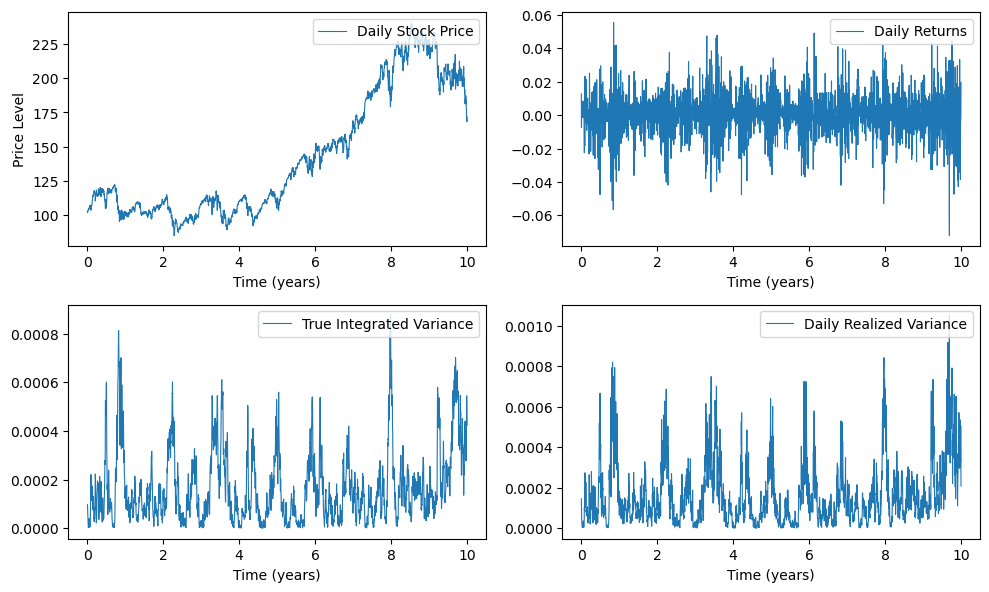

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both - Corr

In [6]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.02, 0.00015, 0.001, 0.001, 0.001, -0.4]) # kappa, theta, xi, mu, sigma, rho

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40626D+04    |proj g|=  8.60172D+04

At iterate    1    f= -1.40999D+04    |proj g|=  5.90000D-01

At iterate    2    f= -1.41033D+04    |proj g|=  1.48739D+02

At iterate    3    f= -1.41060D+04    |proj g|=  1.32855D+05

At iterate    4    f= -1.41072D+04    |proj g|=  2.98323D+02

At iterate    5    f= -1.41073D+04    |proj g|=  3.89396D+03

At iterate    6    f= -1.41076D+04    |proj g|=  2.18288D+04

At iterate    7    f= -1.41086D+04    |proj g|=  6.47671D+04

At iterate    8    f= -1.41100D+04    |proj g|=  9.44646D+04

At iterate    9    f= -1.41124D+04    |proj g|=  7.80505D+04

At iterate   10    f= -1.41133D+04    |proj g|=  2.75695D+04

At iterate   11    f= -1.41135D+04    |proj g|=  5.70160D+03

At iterate   12    f= -1.41135D+04    |proj g|=  2.64567D+02

At iterate   13    f= -1.4

### Return - Corr

In [7]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.02, 0.00015, 0.00138, 0.0002, -0.5]) # kappa, theta, xi, mu, rho

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.83073D+03    |proj g|=  3.44584D+04

At iterate    1    f= -3.84753D+03    |proj g|=  3.01686D+04

At iterate    2    f= -3.85344D+03    |proj g|=  2.82265D+04

At iterate    3    f= -3.86256D+03    |proj g|=  1.88480D+04

At iterate    4    f= -3.86589D+03    |proj g|=  1.93720D+05

At iterate    5    f= -3.86632D+03    |proj g|=  4.74745D+03

At iterate    6    f= -3.86633D+03    |proj g|=  1.70070D+04

At iterate    7    f= -3.86634D+03    |proj g|=  4.91512D+03

At iterate    8    f= -3.86634D+03    |proj g|=  4.88630D+03

At iterate    9    f= -3.86637D+03    |proj g|=  4.77899D+03

At iterate   10    f= -3.86644D+03    |proj g|=  4.62275D+03

At iterate   11    f= -3.86656D+03    |proj g|=  4.43497D+03

At iterate   12    f= -3.86673D+03    |proj g|=  4.34122D+03

At iterate   13    f= -3.8

### PF

In [8]:
pf_heston_train = PFHeston(train_returns, N=10000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.3),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 1058.920254683682
resampling since: 2709.6043636242875
resampling since: 6065.417839672695
resampling since: 3901.2084622978928
resampling since: 6440.889371253871
resampling since: 4540.091707112168
resampling since: 5428.585726527891
resampling since: 2535.2459590466888
resampling since: 5134.842863978734
resampling since: 6994.017787188359
resampling since: 6644.263808695328
resampling since: 5927.882845111254
resampling since: 4617.658761635401
resampling since: 684.1530534955277
resampling since: 665.5642004357163
resampling since: 4664.346142374691
resampling since: 319.95393308473933
resampling since: 6321.367599177624
resampling since: 6270.614343001758
resampling since: 6103.499957019627
resampling since: 4521.462361978136
resampling since: 5397.952235929671
resampling since: 5857.150666254815
resampling since: 6191.410076448311
resampling since: 5420.011781544386
resampling since: 4993.928386181168
resampling since: 6173.996781511498
resampling since: 2081.4

In [9]:
pf_heston_test = PFHeston(test_returns, N=10000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 6186.111056619904
resampling since: 5290.93054054844
resampling since: 6267.550653810991
resampling since: 6469.101026797829
resampling since: 1880.3455496549896
resampling since: 2995.377253827109
resampling since: 6900.6803489203585
resampling since: 5362.472209895191
resampling since: 6624.748608734628
resampling since: 2813.6334096896762
resampling since: 5480.875622671208
resampling since: 6969.5710311442535
resampling since: 6768.661433537605
resampling since: 3304.4574234906277
resampling since: 6820.986309146326
resampling since: 6645.004790775913
resampling since: 6124.49901795478
resampling since: 6554.441999076303
resampling since: 5633.730343010771
resampling since: 1363.3612728846715
resampling since: 6647.8078614121205
resampling since: 6764.152265263111
resampling since: 6632.96879700946
resampling since: 6723.974632162134
resampling since: 5617.328916743622
resampling since: 6973.574938054653
resampling since: 6476.09397807934
resampling since: 5612.88

In [10]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

### Realized GARCH

In [11]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

## Plot

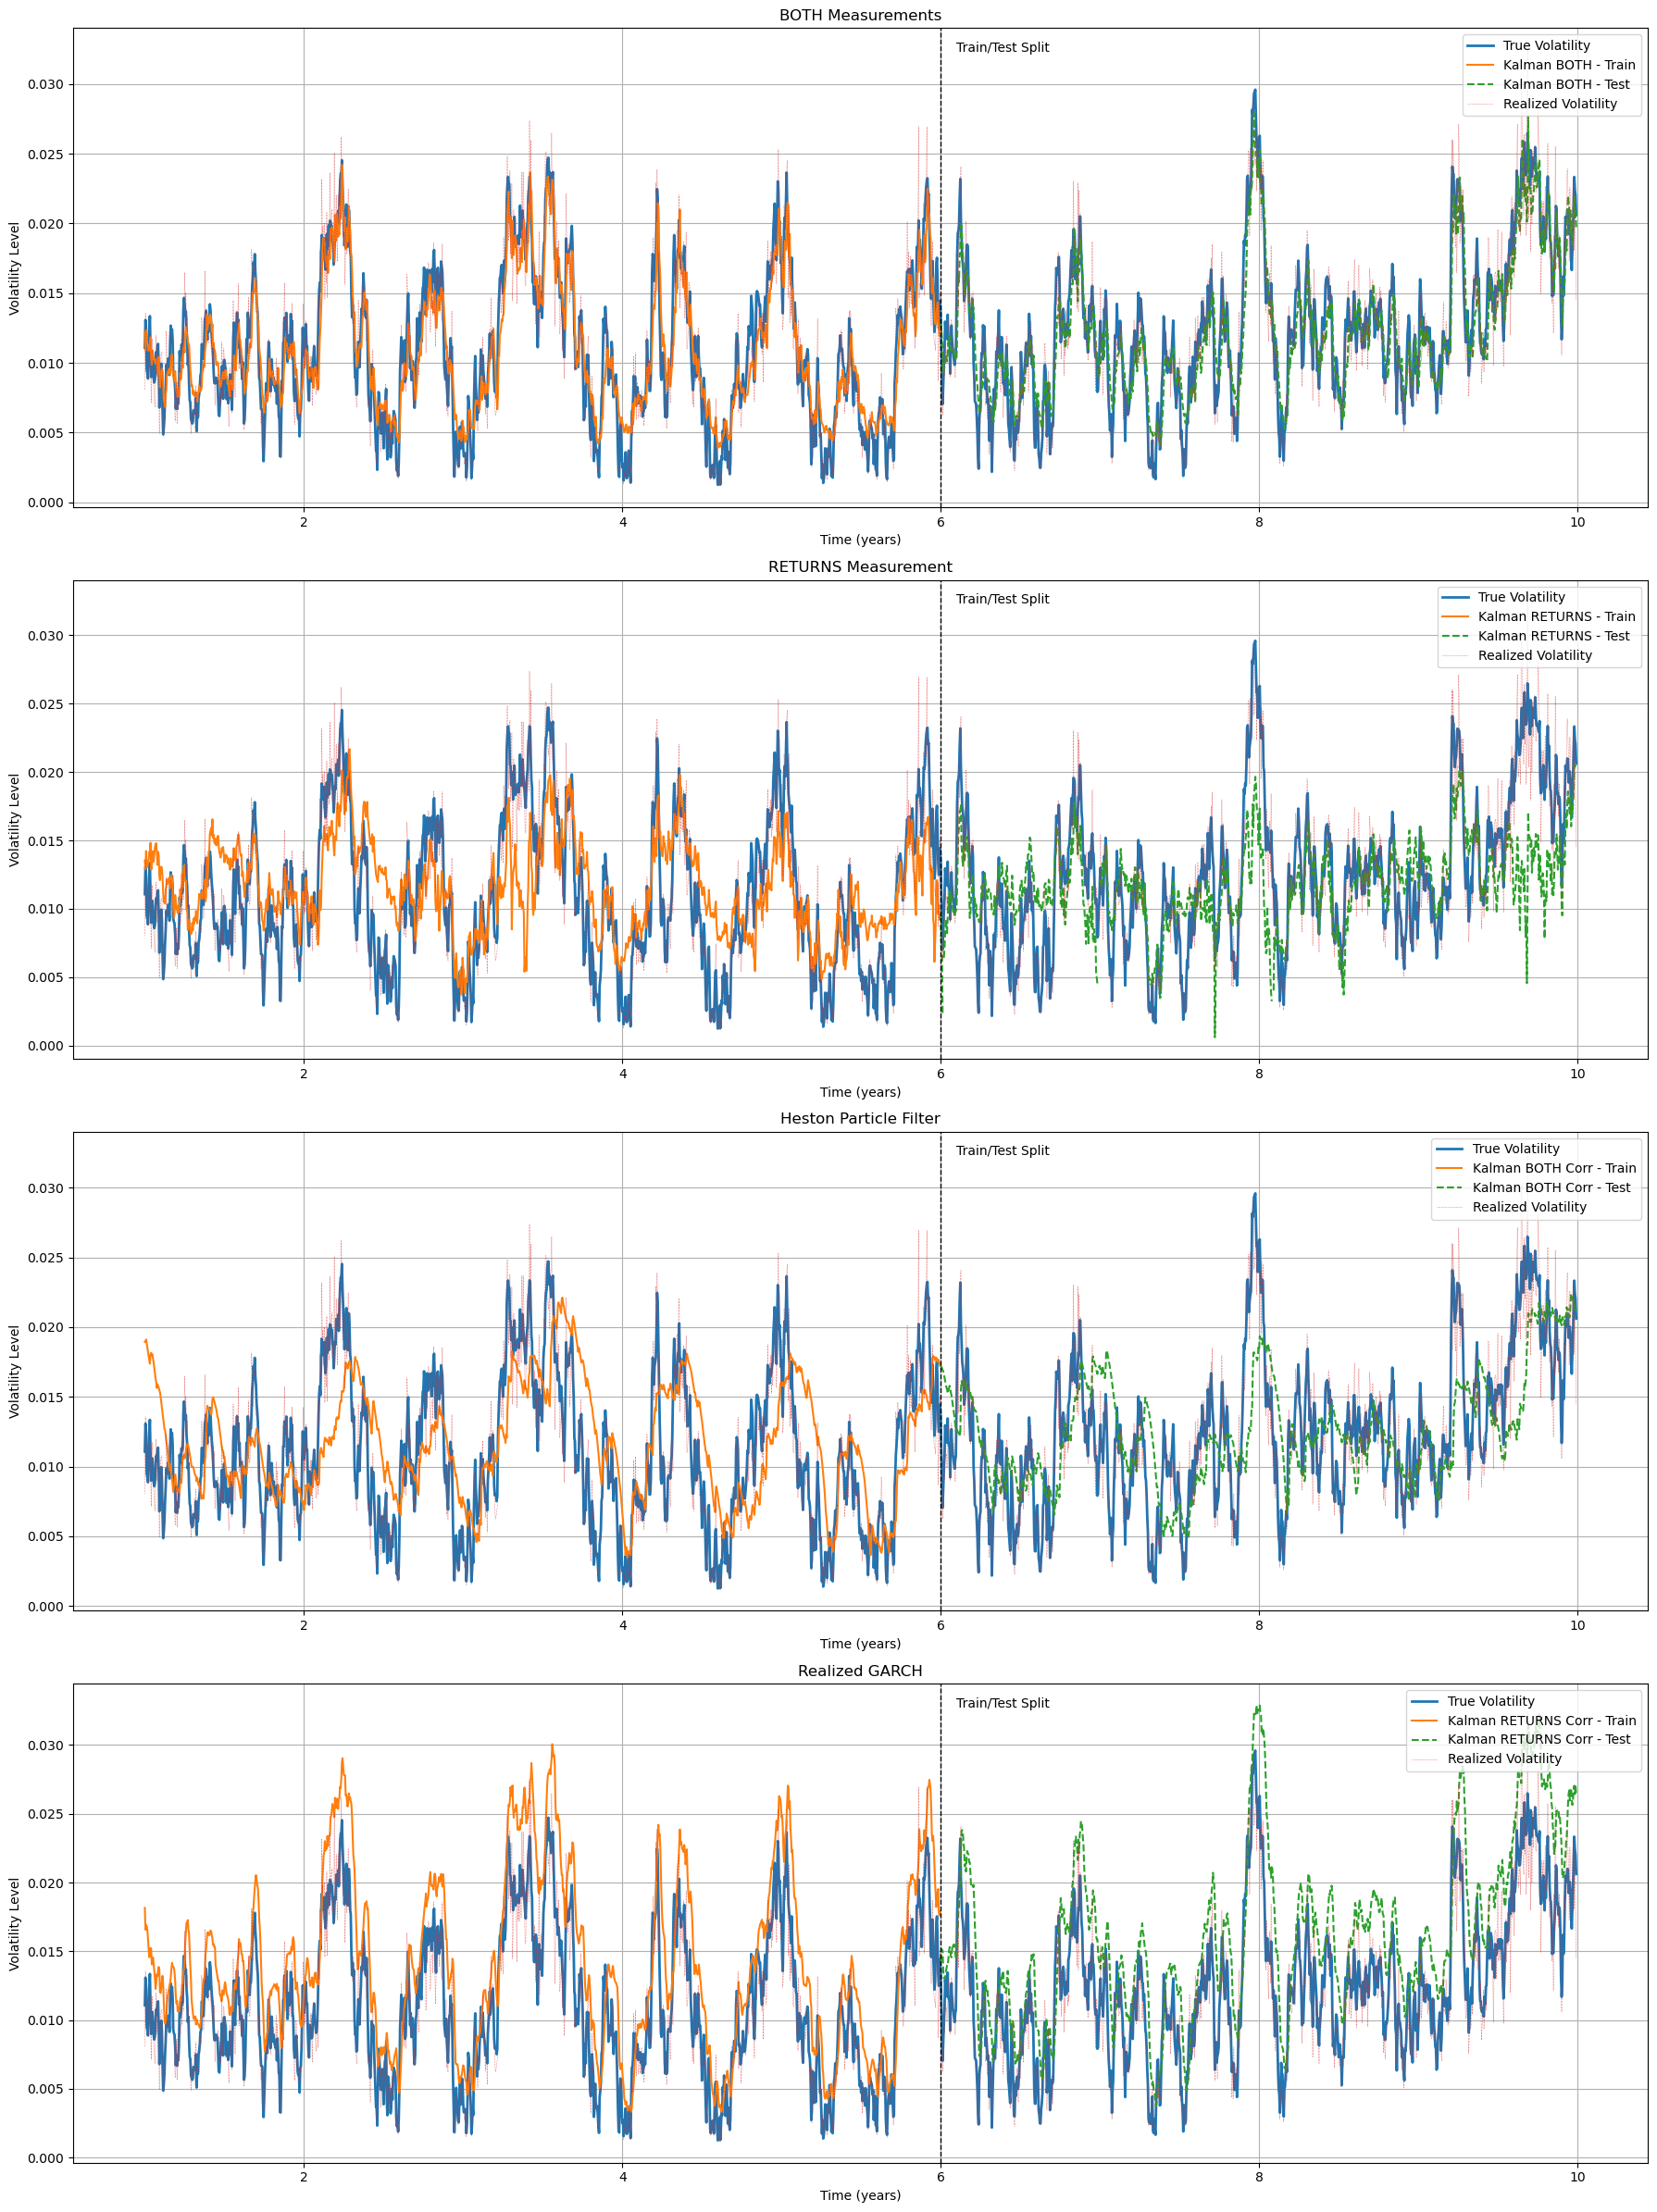

In [12]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], V_pf_test_daily, predicted_vol]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252, 
    save_path=r"./output/high_vol.png"
)

In [13]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'QLKF', 'PF', 'Realized GARCH']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.001980, QLIKE: 0.084850
QLKF               RMSE: 0.004252, QLIKE: 547.254584
PF                 RMSE: 0.004401, QLIKE: 0.298031
Realized GARCH     RMSE: 0.004828, QLIKE: 0.213423


In [14]:
data = {}

data['RV-QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    [*(params_opt_both_corr[:-1] * 252), params_opt_both_corr[-1]]
))

data['QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    [*(params_opt_returns_corr[:-1] * 252), params_opt_returns_corr[-1]]
))
data['QLKF']['sigma'] = np.nan

pf_vals = estimated_param[:, -1]
data['PF'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,RV-QLKF,QLKF,PF
kappa,8.523389,8.493311,1.811107
theta,0.023423,0.037932,0.029569
xi,0.604428,0.939606,0.287752
mu,0.112679,0.043731,-0.039579
sigma,0.092029,NaN,NaN
rho,-0.405517,-0.499959,-0.037313


In [15]:
pd.Series(dict(zip(model.param_names[:-1], np.round(model.params[:-1], 4))))

omega      0.0127
beta       0.8039
gamma      0.1835
xi        -0.4989
phi        0.9391
tau_1      0.0636
tau_2      0.0283
sigma_u    0.2634
dtype: float64

In [16]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse_90 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.10, show_progress=True)
mcs_qlike_90 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.10, show_progress=True)

mcs_mse_75 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.25, show_progress=True)
mcs_qlike_75 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.25, show_progress=True)

mcs_mse_90.compute()
mcs_qlike_90.compute()

mcs_mse_75.compute()
mcs_qlike_75.compute()

mcs_mse_results_90 = mcs_mse_90.results()
mcs_qlike_results_90 = mcs_qlike_90.results()

mcs_mse_results_75 = mcs_mse_75.results()
mcs_qlike_results_75 = mcs_qlike_75.results()

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 1072.16model/s]


In [17]:
mcs_mse_results_90

,pvalues,status
models,,
4,0.0000,excluded
3,0.0001,excluded
2,0.0044,excluded
1,1.0000,included


In [18]:
mcs_qlike_results_90

,pvalues,status
models,,
2,0.0,excluded
3,0.0,excluded
4,0.0,excluded
1,1.0,included


In [19]:
mcs_mse_results_75

,pvalues,status
models,,
4,0.0000,excluded
3,0.0000,excluded
2,0.0041,excluded
1,1.0000,included


In [20]:
mcs_qlike_results_75

,pvalues,status
models,,
2,0.0,excluded
3,0.0,excluded
4,0.0,excluded
1,1.0,included
